In [55]:
import rasterio
from rasterio import plot
import rasterio.mask
import rasterio.warp
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import os
import shapely
from shapely import Point, Polygon, box
import geopandas as gpd
import pandas as pd
import yaml
from sentinelsat import SentinelAPI
from zipfile import ZipFile
import pathlib
from bs4 import BeautifulSoup
from typing import Tuple
from dataclasses import dataclass
from pathlib import Path
import shutil
import ipaddress

from aimlsse_api.client import SatelliteDataClient
from aimlsse_api.data import Credentials, QueryStates

Make sure that the file `login.yml` exists. If not, create a new one and store your credentials for the [Copernicus OpenAPI Hub](https://scihub.copernicus.eu/dhus/#/home) in the following form:
```
username: <copernicus-username>
password: <copernicus-password>
```
The file is excluded from git to make sure that credentials are kept private.

In [39]:
login_config = yaml.safe_load(open('login.yml'))
username = login_config['username']
password = login_config['password']
copernicus_login = Credentials(username, password)

In [40]:
data_dir = 'data'
product_id = '405c25dc-37a3-45bd-b07c-1dce4c56b138'

In [41]:
satellite_client = SatelliteDataClient(ipaddress.ip_address('127.0.0.1'), 8010)
product_state = satellite_client.requestProduct(product_id, copernicus_login)
print(product_state)
assert product_state == QueryStates.AVAILABLE, 'Product must be available before continuing!'

QueryStates.AVAILABLE


In [42]:
zip_filepath = satellite_client.getProduct(product_id, data_dir)
print(zip_filepath)

data\S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430.zip


In [43]:
with ZipFile(zip_filepath) as zip_file:
    zip_file.extractall(data_dir)

In [44]:
product_title = Path(zip_filepath).stem
dirname = product_title + '.SAFE'
metadata_path = os.path.join(data_dir, dirname)
metadata_path = os.path.join(metadata_path, next(filter(lambda x: x.startswith('MTD'), os.listdir(metadata_path))))
print(metadata_path)
image_path = os.path.join(data_dir, dirname, 'GRANULE')
image_path = os.path.join(image_path, os.listdir(image_path)[0], 'IMG_DATA')
print(image_path)

data\S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430.SAFE\MTD_MSIL1C.xml
data\S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430.SAFE\GRANULE\L1C_T13SGT_A039377_20230105T174210\IMG_DATA


In [45]:
Path(os.path.join(data_dir, dirname)).stem

'S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430'

In [46]:
def get_band_name_for_files(name:str) -> str:
    if len(name) < 3:
        # B7 should be B07 etc.
        return name[0] + '0' + name[1:]
    return name

def get_band_name_for_meta(name:str) -> str:
    if name[1] == '0':
        return name[0] + name[2:]
    return name

In [47]:
with open(metadata_path, 'r') as file:
    metadata = file.read()

metadata_soup = BeautifulSoup(metadata, 'xml')
spectral_infos = metadata_soup.find_all('Spectral_Information')
spatial_resolutions = {}
for info in spectral_infos:
    band_name = info.get('physicalBand')
    spatial_resolutions[band_name] = int(info.RESOLUTION.string)
print(spatial_resolutions)

{'B1': 60, 'B2': 10, 'B3': 10, 'B4': 10, 'B5': 20, 'B6': 20, 'B7': 20, 'B8': 10, 'B8A': 20, 'B9': 60, 'B10': 60, 'B11': 20, 'B12': 20}


In [48]:
print(spatial_resolutions.keys())

dict_keys(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12'])


In [49]:
image_files = os.listdir(image_path)
print(image_files)

['T13SGT_20230105T173721_B01.jp2', 'T13SGT_20230105T173721_B02.jp2', 'T13SGT_20230105T173721_B03.jp2', 'T13SGT_20230105T173721_B04.jp2', 'T13SGT_20230105T173721_B05.jp2', 'T13SGT_20230105T173721_B06.jp2', 'T13SGT_20230105T173721_B07.jp2', 'T13SGT_20230105T173721_B08.jp2', 'T13SGT_20230105T173721_B09.jp2', 'T13SGT_20230105T173721_B10.jp2', 'T13SGT_20230105T173721_B11.jp2', 'T13SGT_20230105T173721_B12.jp2', 'T13SGT_20230105T173721_B8A.jp2', 'T13SGT_20230105T173721_TCI.jp2']


In [50]:
def get_image_path(name:str) -> str:
    filename = next(filter(lambda img: img.find(name) >= 0, image_files))
    return os.path.join(image_path, filename)

image_drivers = {
    'jp2': 'JP2OpenJPEG'
}

def open_image(name:str) -> rasterio.DatasetReader:
    image_path = get_image_path(name)
    return rasterio.open(image_path, driver=image_drivers[pathlib.Path(image_path).suffix[1:]])

In [51]:
@dataclass
class SentinelData:
    image: rasterio.DatasetReader
    spatial_resolution: int

def load_sentinel_data(band_name:str) -> SentinelData:
    image = open_image(get_band_name_for_files(band_name))
    spatial_resolution = spatial_resolutions[get_band_name_for_meta(band_name)]
    return SentinelData(image, spatial_resolution)

In [52]:
band2 = load_sentinel_data('B2')
band8 = load_sentinel_data('B8')
band11 = load_sentinel_data('B11')
bands = [band2, band8, band11]

In [53]:
for band in bands:
    print(band.image.crs)

EPSG:32613
EPSG:32613
EPSG:32613


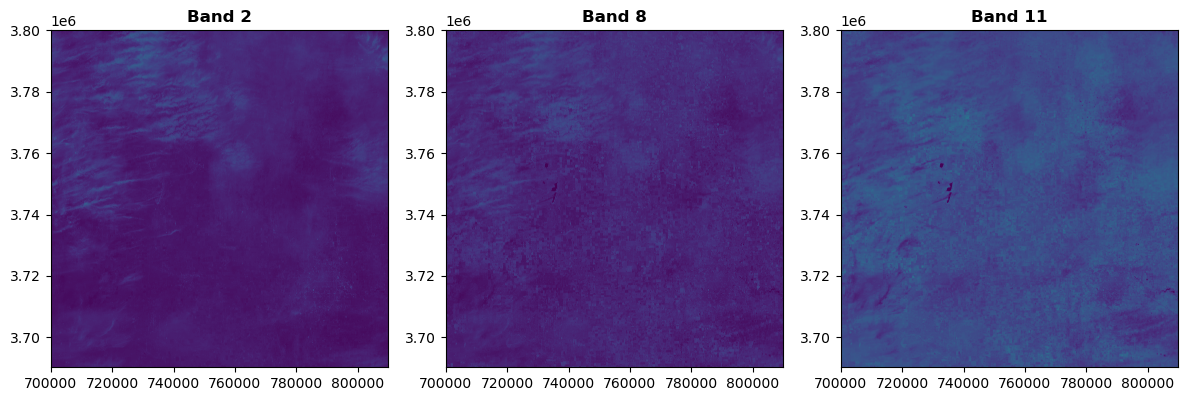

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(band2.image, ax=ax1, title='Band 2')
plot.show(band8.image, ax=ax2, title='Band 8')
plot.show(band11.image, ax=ax3, title='Band 11')
fig.tight_layout()

In [19]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

In [56]:
stations: gpd.GeoDataFrame = gpd.read_file('data/product_stations.geojson')
print(stations.columns)
print(stations)

Index(['id', 'name', 'plot_name', 'network', 'latitude', 'longitude',
       'elevation', 'index_right', 'ISO_A3_EH', 'country', 'CONTINENT',
       'distance_to_region', 'geometry'],
      dtype='object')
       id                     name                plot_name  network  \
0     LBB                  Lubbock                     None   NEXRAD   
1    KREE  Reese Afb/Lubock  TX/US  Reese Afb/Lubock, TX/US     RAOB   
2     LLN                Levelland                Levelland  TX_ASOS   
3     LBB        LUBBOCK INTL ARPT                     None  TX_ASOS   
4     PVW                PLAINVIEW                     None  TX_ASOS   
..    ...                      ...                      ...      ...   
102  XONS                    OLTON                     None      WTM   
103  XPVS                PLAINVIEW                     None      WTM   
104  XREE                    REESE                     None      WTM   
105  XSDS                  SUNDOWN                     None      WTM   
10

In [57]:
stations['geometry'] = stations['geometry'].apply(lambda location: reproject_point(location, CRS.from_epsg(4326), band11.image.crs))
print(stations[['id', 'geometry']])

       id                            geometry
0     LBB  POINT (795466.90865 3728348.58989)
1    KREE  POINT (778384.96759 3721841.60845)
2     LLN  POINT (743942.41882 3715632.66411)
3     LBB  POINT (794619.43130 3729392.94009)
4     PVW  POINT (802609.49336 3785672.12529)
..    ...                                 ...
102  XONS  POINT (765722.85543 3775880.13481)
103  XPVS  POINT (803243.94871 3787008.70184)
104  XREE  POINT (773711.96556 3722817.40474)
105  XSDS  POINT (722302.03474 3697076.25034)
106  XWOS  POINT (774311.67287 3701741.26044)

[107 rows x 2 columns]


In [58]:
def get_area_of_observation(point:Point, radius:float) -> Polygon:
    return box(
        point.x - radius,
        point.y - radius,
        point.x + radius,
        point.y + radius
    )

In [59]:
selected_band_name = 'B2'
selected_band = band2
radius_meters = 3000

In [60]:
stations['bbox'] = stations['geometry'].apply(lambda location: get_area_of_observation(location, radius_meters))
print(stations['bbox'])

0      POLYGON ((798466.90865 3725348.58989, 798466.9...
1      POLYGON ((781384.96759 3718841.60845, 781384.9...
2      POLYGON ((746942.41882 3712632.66411, 746942.4...
3      POLYGON ((797619.43130 3726392.94009, 797619.4...
4      POLYGON ((805609.49336 3782672.12529, 805609.4...
                             ...                        
102    POLYGON ((768722.85543 3772880.13481, 768722.8...
103    POLYGON ((806243.94871 3784008.70184, 806243.9...
104    POLYGON ((776711.96556 3719817.40474, 776711.9...
105    POLYGON ((725302.03474 3694076.25034, 725302.0...
106    POLYGON ((777311.67287 3698741.26044, 777311.6...
Name: bbox, Length: 107, dtype: geometry


In [61]:
def transform_image(band: rasterio.DatasetReader, bounding_box:Polygon):
    out_image, out_transform = rasterio.mask.mask(band, [bounding_box], crop=True)
    out_meta = band.meta
    return out_image, out_transform, out_meta

In [62]:
out_data = stations['bbox'].apply(lambda bbox: transform_image(selected_band.image, bbox))

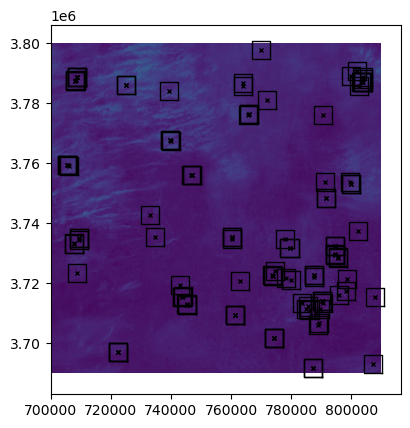

In [78]:
enable_labels = False

fig, ax = plt.subplots()
plot.show(selected_band.image, ax=ax)
for station in stations['geometry']:
    ax.plot(*station.xy, color='black', marker='x', markersize=3)
for bbox in stations['bbox']:
    ax.plot(*bbox.exterior.xy, color='black', linewidth=1)
if enable_labels:
    stations.apply(lambda station:
        ax.text(station['geometry'].x + radius_meters * 1.2, station['geometry'].y - radius_meters * 0.4, station['id']),
        axis = 1
    )

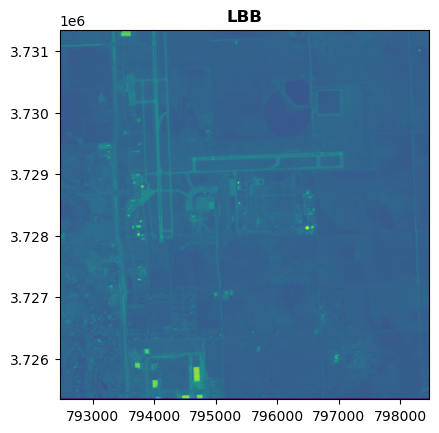

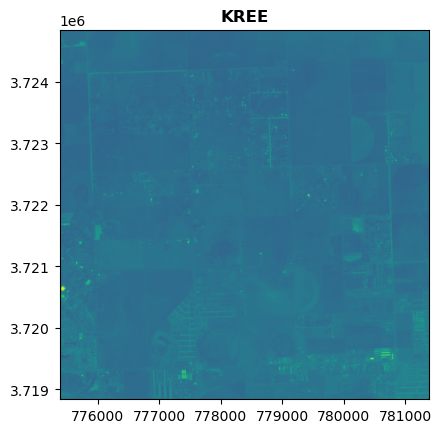

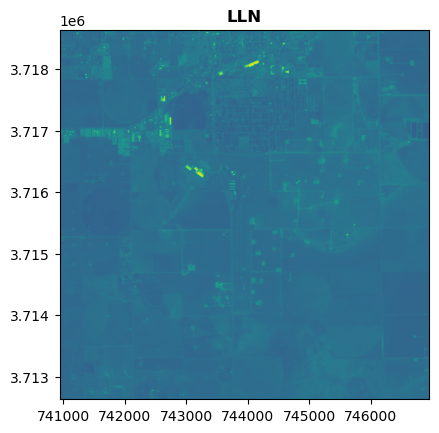

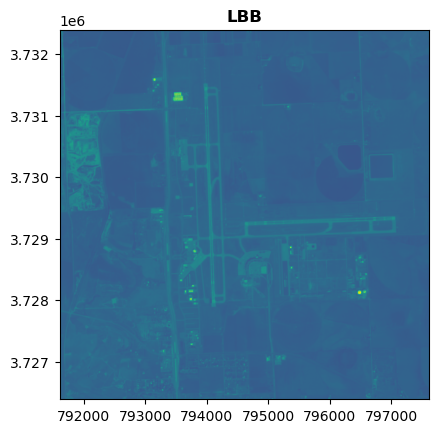

In [65]:
index = 0
for image, transform, meta in out_data:
    if index > 3:
        break
    plot.show(image, transform=transform, title=stations['id'].iloc[index])
    index += 1

In [66]:
for image, transform, meta in out_data:
    area = (image.shape[1], image.shape[2])
    res = selected_band.spatial_resolution
    print(f'Shape is {area} with spatial-resolution {res}: ({area[0] * res} m, {area[1] * res} m)')

Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (558, 601) with spatial-resolution 10: (5580 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with spatial-resolution 10: (6010 m, 6010 m)
Shape is (601, 601) with 

In [67]:
band_bounds = selected_band.image.bounds
band_bounds = box(band_bounds.left, band_bounds.bottom, band_bounds.right, band_bounds.top)
print(band_bounds)

POLYGON ((809760 3690240, 809760 3800040, 699960 3800040, 699960 3690240, 809760 3690240))


In [68]:
print(stations['bbox'][0].bounds)

(792466.9086491873, 3725348.5898889173, 798466.9086491873, 3731348.5898889173)


In [69]:
def check_containment(bounds_outer:Polygon, bounds_inner:Polygon, station_name:str):
    is_complete = bounds_outer.contains(bounds_inner)
    is_complete_str = 'complete' if is_complete else 'incomplete'
    print(f'Containment of station {station_name} is {is_complete_str}')

In [71]:
stations.apply(lambda station: check_containment(band_bounds, station['bbox'], station['id']), axis=1)

Containment of station LBB is complete
Containment of station KREE is complete
Containment of station LLN is complete
Containment of station LBB is complete
Containment of station PVW is complete
Containment of station TX0012 is complete
Containment of station TX3862 is complete
Containment of station TX3864 is complete
Containment of station TX3976 is incomplete
Containment of station TX5183 is complete
Containment of station TX5265 is complete
Containment of station TX5263 is complete
Containment of station TX5408 is complete
Containment of station TX5410 is complete
Containment of station TXTLBB is complete
Containment of station TX5411 is complete
Containment of station TX5409 is complete
Containment of station TX6074 is complete
Containment of station TX6135 is complete
Containment of station TX6136 is complete
Containment of station TX6137 is complete
Containment of station TX6644 is complete
Containment of station TX6981 is complete
Containment of station TX7079 is complete
Cont

0      None
1      None
2      None
3      None
4      None
       ... 
102    None
103    None
104    None
105    None
106    None
Length: 107, dtype: object

In [73]:
def image_to_file(out_image, out_transform, out_meta, filepath:str, driver:str):
    out_meta.update({
        "driver": driver,
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    print(filepath)
    with rasterio.open(filepath, "w", **out_meta) as dest:
        dest.write(out_image)

In [76]:
named_out_data = pd.DataFrame({'id': stations['id'], 'out': out_data})
print(named_out_data.columns)
out_dir = os.path.join('out/', product_title)
out_band_dir = os.path.join(out_dir, selected_band_name)
os.makedirs(out_band_dir, exist_ok=True)
named_out_data.apply(lambda row: image_to_file(
        row['out'][0],
        row['out'][1],
        row['out'][2],
        os.path.join(out_band_dir, row['id'] + '.jp2'),
        image_drivers['jp2']
    ), axis=1)

Index(['id', 'out'], dtype='object')
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\LBB.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\KREE.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\LLN.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\LBB.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\PVW.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\TX0012.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\TX3862.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\TX3864.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\TX3976.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\TX5183.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\TX5265.jp2
out/S2A_MSIL1C_20230105T173721_N0509_R055_T13SGT_20230105T205430\B2\TX5263.jp2
out/S2A_MSIL1C_20230105T17372

0      None
1      None
2      None
3      None
4      None
       ... 
102    None
103    None
104    None
105    None
106    None
Length: 107, dtype: object

In [77]:
out_zip = shutil.make_archive(out_dir, 'zip', out_dir)